In [1]:
import os
import skimage
from pathlib import Path
import sys
import random
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
%matplotlib inline
sys.path.append('./Mask_RCNN')
from mrcnn import utils, visualize
from mrcnn import model as modellib
from mrcnn.model import log
from Overlay3D import Overlay3DConfig, Overlay3DDataset
from Sixd import SixdConfig, SixdDataset
from hinterstoisser import HinterstoisserConfig, HinterstoisserDatasetRGB, HinterstoisserDatasetRGBD, HinterstoisserDatasetD
os.environ['CUDA_VISIBLE_DEVICES'] = ''

def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

/home/mjakobsen/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
configs = []
datasets = []

class InferenceConfig(HinterstoisserConfig):   
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

class HinterstoisserConfigRGB1(InferenceConfig):
    NAME = 'hinterstoisser_rgb_bottom_up'
configs.append(HinterstoisserConfigRGB1())
datasets.append(HinterstoisserDatasetRGB())
    
class HinterstoisserConfigRGB2(InferenceConfig):
    NAME = 'hinterstoisser_rgb_coco'
configs.append(HinterstoisserConfigRGB2())
datasets.append(HinterstoisserDatasetRGB())

class HinterstoisserConfigD3(InferenceConfig):
    NAME = 'hinterstoisser_depth_only'
    IMAGE_CHANNELS = 1
configs.append(HinterstoisserConfigD3())
datasets.append(HinterstoisserDatasetD())
    
class HinterstoisserConfigRGBDnorm(InferenceConfig):
    NAME = "hinterstoisser_rgbd_bottom_up_jointly_norm"
    IMAGE_CHANNELS = 4
    MEAN_PIXELS = np.zeros(4)
    
class HinterstoisserDatasetRGBDnorm(HinterstoisserDatasetRGB):
    def load_image(self, image_id):
        info = self.image_info[image_id]
        rgb = skimage.io.imread(info['path'])
        depth = skimage.io.imread(str(
            Path(info['path']).parent.parent / 'depth' / '{:04}.png'.format(info['id'])
        )).reshape((*rgb.shape[:2], 1))
        depth = (depth.astype(np.float32) - 950.) / 460.
        rgb = (rgb.astype(np.float32) - [84., 79., 78.]) / 62.
        return np.concatenate((rgb, depth), axis=-1)
configs.append(HinterstoisserConfigRGBDnorm())
datasets.append(HinterstoisserDatasetRGBDnorm())
    
class HinterstoisserConfigRGBD6(InferenceConfig):
    NAME = "hinterstoisser_rgbd_bottom_up_separate"
    SECONDARY_MODE = "before_rpn"
    SECONDARY_CHANNELS = 1
configs.append(HinterstoisserConfigRGBD6())
datasets.append(HinterstoisserDatasetRGBD())

class HinterstoisserConfigRGBD7(InferenceConfig):
    NAME = "hinterstoisser_rgb_coco_d_bottom"
    SECONDARY_MODE = "before_rpn"
    SECONDARY_CHANNELS = 1
configs.append(HinterstoisserConfigRGBD7())
datasets.append(HinterstoisserDatasetRGBD())
    
class HinterstoisserConfigRGBD8(InferenceConfig):
    NAME = "hinterstoisser_rgbd_pretrained_rgb_d"
    SECONDARY_MODE = "before_rpn"
    SECONDARY_CHANNELS = 1
configs.append(HinterstoisserConfigRGBD8())
datasets.append(HinterstoisserDatasetRGBD())

class Overlay3DConfigRGB(Overlay3DConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
configs.append(Overlay3DConfigRGB())
datasets.append(Overlay3DDataset())

class SixdConfigRGB(SixdConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
configs.append(SixdConfigRGB())
datasets.append(SixdDataset())

models = [None for _ in range(len(datasets))]

In [3]:
model_path = []
model_path.append('logs/hinterstoisser_rgb_20180511T0924/mask_rcnn_hinterstoisser_rgb_only_0100.h5') # rgb
model_path.append('logs/hinterstoisser_rgb_coco20180514T1037/mask_rcnn_hinterstoisser_rgb_coco_0100.h5') # rgb coco
model_path.append('logs/hinterstoisser_depth_only_20180507T1114/mask_rcnn_hinterstoisser_0100.h5') # d
model_path.append('logs/hinterstoisser_rgbd_bottom_up_jointly20180514T2233/mask_rcnn_hinterstoisser_rgbd_bottom_up_jointly_0100.h5') # rgbd norm
model_path.append('logs/hinterstoisser_rgbd_bottom_up_separate_20180509T0827/mask_rcnn_hinterstoisser_rgbd_0100.h5') # rgb + d
model_path.append('logs/hinterstoisser_rgb_on_coco_depth_on_hinterstoisser_20180509T2329/mask_rcnn_hinterstoisser_rgbd_0100.h5') #rgb coco + d
model_path.append('logs/hinterstoisser_rgbd_coco_train_heads_depth_20180503T1059/mask_rcnn_hinterstoisser_0100.h5') #rgb coco + d hinterstoisser

model_path.append('logs/sixd20180406T1527/mask_rcnn_sixd_0004.h5')
model_path.append('logs/overlay3d20180420T0727/mask_rcnn_overlay3d_0014.h5')

In [6]:
dataset_dir = '../datasets/sixd/hinterstoisser/'
dataset_sixd_dir = '../datasets/sixd/doumanoglou'

In [5]:
dataset_test = Overlay3DDataset()
dataset_test.load_overlay3d(dataset_sixd_dir + '/test')
dataset_test.prepare()

In [16]:
from sixd_test import SixdTestDataset
dataset_test = SixdTestDataset()
dataset_test.load_sixd_test("/home/rhaugaard/shared/3D-pose-est-aid/datasets/sixd/doumanoglou/test", "/home/mjakobsen/workspace/scene-annotator/output/scene-annotator")
dataset_test.prepare()

In [4]:
dataset_val = SixdDataset()
dataset_val.load_sixd(250, '../datasets/coco', 'val', '../datasets/sixd/doumanoglou/train')
dataset_val.prepare()

Using cached definition file: image_def_val2017_250.yaml


In [4]:
model_id = 1 
with tf.device("/gpu:1"):
    models[model_id] = modellib.MaskRCNN(mode="inference", config=configs[model_id], model_dir='logs')
models[model_id].load_weights(model_path[model_id], by_name=True)

#datasets[model_id].load_hinterstoisser(dataset_dir, 2, 'test_set_v1')
#datasets[model_id].prepare()

In [6]:
test_inx = np.array([3, 8, 17, 27, 36, 38, 39, 41, 47, 58, 61, 62, 64, 65, 69, 72, 79, 89, 96, 97, 102, 107, 110, 115, 119, 124, 126, 136, 153, 156, 162, 166, 175, 176, 178, 203, 207, 217, 219, 221, 224, 243, 248, 249, 254, 258, 263, 266, 268, 277, 283, 307, 310, 322, 326, 338, 342, 356, 362, 365, 368, 387, 389, 402, 415, 417, 425, 428, 434, 435, 438, 442, 446, 453, 473, 474, 476, 477, 480, 491, 494, 499, 501, 503, 521, 527, 529, 532, 535, 540, 543, 549, 560, 563, 571, 575, 589, 603, 607, 611, 615, 625, 642, 648, 649, 650, 652, 667, 669, 679, 691, 695, 703, 708, 711, 727, 736, 737, 739, 740, 750, 754, 756, 757, 758, 761, 762, 764, 768, 769, 770, 773, 775, 785, 788, 791, 794, 801, 803, 804, 808, 809, 819, 821, 828, 837, 840, 844, 850, 856, 867, 871, 877, 883, 886, 894, 902, 903, 904, 907, 909, 918, 925, 934, 942, 952, 956, 961, 968, 969, 972, 982, 984, 991, 1001, 1012, 1038, 1050, 1057, 1061, 1069, 1071, 1087, 1098, 1099, 1103, 1107, 1117, 1123, 1131, 1144, 1148, 1151, 1157, 1168, 1169, 1176, 1180, 1199, 1212])

In [7]:
dataset_test = datasets[model_id]
dataset_test.load_hinterstoisser(dataset_dir, 2, 'test_set_v1')
dataset_test.prepare()

../datasets/sixd/hinterstoisser/test/02
../datasets/sixd/hinterstoisser/test_set_v1.yml


In [26]:
# Draw precision-recall curve
AP50, precisions50, recalls50, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'],0.50)
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'],0.75)

[0.75       0.75       0.75       0.75       0.75       0.6
 0.5        0.42857143 0.375      0.33333333 0.        ] [0.         0.         0.11111111 0.22222222 0.33333334 0.33333334
 0.33333334 0.33333334 0.33333334 0.33333334 1.        ]
[1.         1.         1.         1.         1.         1.
 0.85714286 0.85714286 0.75       0.66666667 0.        ] [0.         0.11111111 0.22222222 0.33333334 0.44444445 0.55555558
 0.55555558 0.66666669 0.66666669 0.66666669 1.        ]


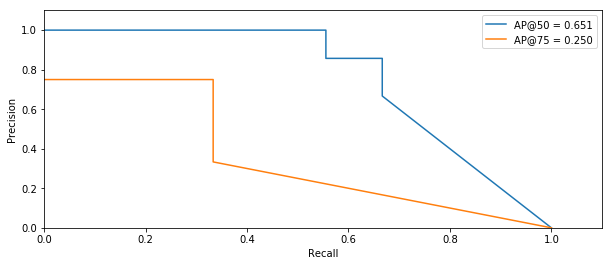

In [69]:
# Plot the Precision-Recall curve
print(precisions, recalls)
print(precisions50, recalls50)
_, ax = plt.subplots(1, figsize=(10,4))
#ax.set_title("Precision-Recall Curve")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_ylim(0, 1.1)
ax.set_xlim(0, 1.1)
_ = ax.plot(recalls50, precisions50)
_ = ax.plot(recalls, precisions)
plt.legend(('AP@50 = {:.3f}'.format(AP50),'AP@75 = {:.3f}'.format(AP)), loc='upper right')

In [9]:
import itertools
import colorsys
from skimage.measure import find_contours
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import IPython.display
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw


def random_colors(N, bright=True, rand=False):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    if rand:
        random.shuffle(colors)
    return colors

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    figsize: (optional) the size of the image.
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # Generate random colors
    #colors = random_colors(20, random=True)

    masked_image = image.copy()
    for i in range(N):
        class_id = class_ids[i]
        color = colors[i]
        #color = colors[class_id]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]

        # Label
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        label = class_names[class_id]
        x = random.randint(x1, (x1 + x2) // 2)
        caption = "{}\n{:.3f}".format(label, score) if score else label
        
        # Mask
        mask = masks[:, :, i]
        masked_image = apply_mask(masked_image, mask, color)
        
        # Text
        cog = np.mean(np.where(mask == 1), axis=1)
        pil_img = Image.fromarray(masked_image)        
        pil_draw = ImageDraw.Draw(pil_img)
        font = ImageFont.truetype("Roboto-Regular.ttf", 16)
        ts = pil_draw.textsize(caption, font)
        pil_draw.multiline_text((cog[1]-ts[0]//2, cog[0]-ts[1]//2),caption,(255,255,255), font=font, align='center')
        masked_image = np.array(pil_img)
        
    return masked_image

In [6]:
dataset_train = Overlay3DDataset()
dataset_train.load_overlay3d('../datasets/sixd/overlay_3D/4k' + '/train')
dataset_train.prepare()

dataset_val = Overlay3DDataset()
dataset_val.load_overlay3d('../datasets/sixd/overlay_3D/4k' + '/val')
dataset_val.prepare()

In [12]:
#dataset_test = dataset_val
colors = random_colors(40, rand=True)
from skimage import io

original_image = np.pad(Image.open("../datasets/sixd/hinterstoisser/test/02/rgb/1114.png"), 
                    [(80, 80), (0, 0), (0, 0)], mode='constant', constant_values=0)
model = models[model_id]
results = model.detect([original_image], verbose=1)
r = results[0]
    
pred_img = display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'])

img = pred_img[80:-80,:,:]
fp = "rgb_coco_results/{}/{}.png".format("pred", "1114")
io.imsave(fp, img)

Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max:  640.00000  int64
anchors                  shape: (1, 102300, 4)        min:   -0.28329  max:    1.18313  float32


In [18]:
colors = random_colors(40)
from skimage import io
model = models[model_id]
for image_id in dataset_test.image_ids[59:60]:
    print(dataset_test.image_info[image_id]['path'])
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, configs[1], 
                               image_id, use_mini_mask=False)
    results = model.detect([original_image], verbose=1)
    r = results[0]
    gt_img = display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_test.class_names)
    pred_img = display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_test.class_names, r['scores'])

    for i, (img, dirr) in enumerate(zip([pred_img], ["test"])):
        img = img[80:-80,:,:]
        fp = "{}/{}.png".format(dirr, image_id)
        io.imsave(fp, img)

../datasets/sixd/hinterstoisser/test/02/rgb/0365.png
Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 28)               min:    0.00000  max:  640.00000  int64
anchors                  shape: (1, 102300, 4)        min:   -0.28329  max:    1.18313  float32


In [149]:
model_id = 1
name = "hole_puncher"
img, _, _, pad, _ = utils.resize_image(io.imread(name + ".jpg"), 640, 640)
img = modellib.mold_image(img, config)
print(pad)
results = models[model_id].detect([img])
r = results[0]
img = display_instances(modellib.unmold_image(img, config), r['rois'], r['masks'], r['class_ids'], 
                            datasets[model_id].class_names, r['scores'])
img = img[pad[0][0]:-pad[0][1]-1, pad[1][0]:-pad[1][1]-1]
print(img.shape)
io.imsave("generalisation_results/{}_{}.png".format(model_id, name), img)

[(123, 123), (0, 0), (0, 0)]
(393, 639, 3)


In [152]:
model_id = 1
layers = models[model_id].get_trainable_layers()
for l in layers:
    weight_values = l.get_weights()  # list of Numpy arrays
    weight_tensors = l.weights  # list of TF tensors
    for i, w in enumerate(weight_values):
        weight_name = weight_tensors[i].name
        print('weight_name')

weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weight_name
weig